In [1]:
!CUDA_VISIBLE_DEVICE=1

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE

UMAP

In [2]:
def load_VAE():
    autoencoder = VAE(
        num_genes=19423, 
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/home/workplace/cfDiffusion/checkpoint/VAE/wot/model_seed=0_step=800000.pt'))
    return autoencoder

real data

In [3]:
adata = sc.read_h5ad('/home/workplace/cfDiffusion/dataset/WOT_dataset/WOT_filted_data.h5ad')
adata = adata[np.where(np.in1d(adata.obs['period'], ['D0','D0.5','D1','D1.5','D2','D2.5','D3','D4.5','D5','D5.5','D6','D6.5','D7','D7.5','D8']))[0]]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[np.where(adata.obs['period'].values.isnull()==0)[0]]#[::5]

gene_names = adata.var_names

celltype = adata.obs['period']
cell_data = adata.X
cell_data.shape

/home/zqzhao/software/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


(82920, 19423)

In [4]:
np.unique(adata.obs['period'].values)

array(['D0', 'D0.5', 'D1', 'D1.5', 'D2', 'D2.5', 'D3', 'D4.5', 'D5',
       'D5.5', 'D6', 'D6.5', 'D7', 'D7.5', 'D8'], dtype=object)

conditional generated data

In [5]:
cell_gen_all = []
gen_class = []
cato = ['D0', 'D0.5', 'D1', 'D1.5', 'D2', 'D2.5', 'D3', 'D4.5', 'D5', 'D5.5', 'D6', 'D6.5',
        'D7', 'D7.5', 'D8']

index2 = [i for i in range(len(cato))]
for i in index2:
    npyfile=np.load(f'/home/workplace/cfDiffusion/generation/wot/cell{i}_cache5.npy',allow_pickle=True)
    length = min(adata[adata.obs['period']==cato[i]].X.shape[0],9000)
    print(length)
    cell_gen_all.append(npyfile[:int(length)])#.squeeze(1)
    
    gen_class+=['generation '+cato[i]]*int(length)

cell_gen_all = np.concatenate(cell_gen_all,axis=0)

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

cell_gen = cell_gen_all
cell_gen.shape 

4613
3449
3679
1956
7675
6809
6818
7127
7227
6550
8422
3111
6507
5061
3916


(82920, 19423)

plot UMAP

In [6]:
adata = np.concatenate((cell_data, cell_gen),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)

adata.obs['period'] = np.concatenate((celltype, gen_class))
adata.obs['cell_name'] = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]

In [7]:
# the data is already log norm
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

/home/zqzhao/software/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/zqzhao/software/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

In [14]:
sc.settings.set_figure_params(dpi_save=600, format='svg')
# plt.figure(figsize=(8, 8))
sc.pl.umap(adata, color="cell_name", size=8, title='wot', show=False, save='umap_plot.svg')
plt.close()

/home/zqzhao/software/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/zqzhao/software/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


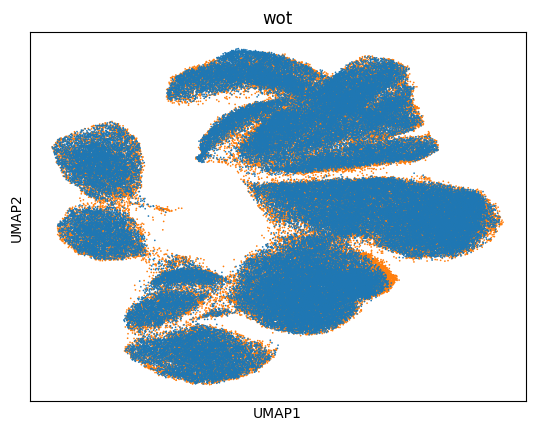

In [10]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
try:
    sc.pl.umap(adata=adata,color="cell_name",size=6,title='wot')
except:
    pass

draw plot of each cell type if conditional generation

In [10]:
adata.obs['period']#.cat.category

0                    D3
1                    D3
2                    D3
3                    D3
4                    D3
              ...      
165835    generation D8
165836    generation D8
165837    generation D8
165838    generation D8
165839    generation D8
Name: period, Length: 165840, dtype: object

In [13]:
np.unique(adata.obs['period'].values)

array(['D0', 'D0.5', 'D1', 'D1.5', 'D2', 'D2.5', 'D3', 'D4.5', 'D5',
       'D5.5', 'D6', 'D6.5', 'D7', 'D7.5', 'D8', 'generation D0',
       'generation D0.5', 'generation D1', 'generation D1.5',
       'generation D2', 'generation D2.5', 'generation D3',
       'generation D4.5', 'generation D5', 'generation D5.5',
       'generation D6', 'generation D6.5', 'generation D7',
       'generation D7.5', 'generation D8'], dtype=object)

In [20]:
cato

['D0',
 'D0.5',
 'D1',
 'D1.5',
 'D2',
 'D2.5',
 'D3',
 'D4.5',
 'D5',
 'D5.5',
 'D6',
 'D6.5',
 'D7',
 'D7.5',
 'D8']

In [23]:
plot_loc = [[i+1, j+1] for i in range(5) for j in range(3)]
plot_loc

[[1, 1],
 [1, 2],
 [1, 3],
 [2, 1],
 [2, 2],
 [2, 3],
 [3, 1],
 [3, 2],
 [3, 3],
 [4, 1],
 [4, 2],
 [4, 3],
 [5, 1],
 [5, 2],
 [5, 3]]

In [13]:
# Create a figure with 5 rows and 3 columns
fig, axes = plt.subplots(5, 3, figsize=(20, 16))

# Initialize the axis index
plot_loc = [[i, j] for i in range(5) for j in range(3)]

for i, category in enumerate(cato):
    color_dict = {}
    for cat in np.unique(adata.obs['period'].values):
        if cat == category:
            color_dict[cat] = 'tab:orange'
        elif cat == 'generation ' + category:
            color_dict[cat] = 'tab:blue'
        else:
            color_dict[cat] = 'black'
    
    ax = axes[plot_loc[i][0]][plot_loc[i][1]]
    sc.settings.set_figure_params(dpi_save=600, format='svg')

    # Create the UMAP plot
    sc.pl.umap(adata, color="period", groups=[category, 'generation ' + category], 
        palette=color_dict, ax=ax, show=False, title=f'period {category}')
    print(i)
    break
    # ax.title(category)

plt.tight_layout()
# plt.show()
# Save the figure
plt.savefig('combined_plot.svg', bbox_inches='tight')

plt.close()

/home/zqzhao/software/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


0
